In [ ]:

#!pip install tensorflow==2.8

In [ ]:
#!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [54]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import shutil

import imageio
import cv2 as cv

import matplotlib.pyplot as plt
%matplotlib inline

random.seed(1)

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
# Checkout if Colab connects to GPU.
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
#%cd /content/drive/MyDrive/02_30_03_23_UWMGT

In [7]:

count_file=0
for root, dirs, files in os.walk('/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/cropped_images'):
    for f in files: 
        if f.endswith('.png'):
            count_file +=1
print(f'number fo images: ',count_file)

number fo images:  0


In [8]:

count_file=0
for root, dirs, files in os.walk('/kaggle/input/uwmgi-mask-dataset/cleaned_data/cropped_masks'):
    for f in files: 
        if f.endswith('.png'):
            count_file +=1
print(f'number fo images: ',count_file)

number fo images:  0


# **2. Load and Split the Data**

2.1. Load the Dataset

In [9]:

# This folder consists of processed data
image_path = os.path.join('/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/cropped_images/')
mask_path = os.path.join('/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/cropped_masks/')

image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)

image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [10]:
# Check out number of unmasked and masked images in each folder
print(f'number of unmasked images:{len(image_list)}')
print(f'number of masked images:{len(mask_list)}')

number of unmasked images:16590
number of masked images:16590


In [11]:
import os
import glob
root_dir = '/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/'
def search_files(root_dir):
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if not file.endswith('.png'):
                print(os.path.join(subdir, file))
             


In [12]:
#search_files('cleaned_data/cropped_images')

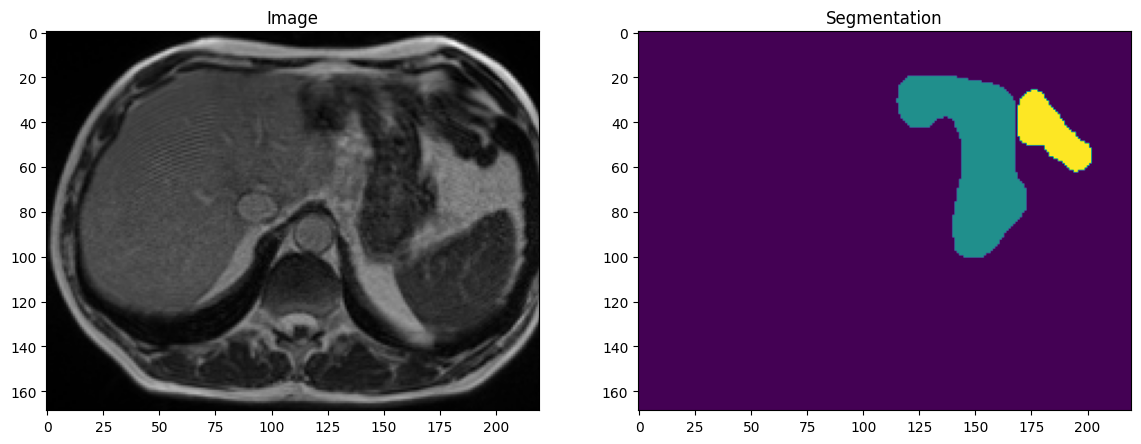

In [13]:
N = 1600
img = cv.imread(image_list[N])
mask = cv.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14,10))
arr[0].imshow(img, cmap='gray')
arr[0].set_title('Image')
arr[1].imshow(cv.cvtColor(mask, cv.COLOR_RGB2GRAY))
arr[1].set_title('Segmentation')
plt.show()

## **2.2. Split Data to Training, Validation and Test**

In [14]:
# Define a function to split data to train, validation and test
def split_data(IMAGE_SOURCE_DIR, MASK_SOURCE_DIR, IMAGE_TRAINING_DIR, MASK_TRAINING_DIR,
               IMAGE_VALIDATION_DIR, MASK_VALIDATION_DIR, IMAGE_TEST_DIR, MASK_TEST_DIR, 
               TRAIN_SIZE, VALID_SIZE, TEST_SIZE):
  
    files = []
  for f in os.listdir(IMAGE_SOURCE_DIR):
    file_name = IMAGE_SOURCE_DIR + f
    if os.path.getsize(file_name) > 0:
      files.append(f)
    else:
      print(file_name, ' is zero size, so ignoring!')

  train_len = int(len(files) * TRAIN_SIZE)
  valid_len = int(len(files) * VALID_SIZE)
  test_len = int(len(files) * TEST_SIZE)

  shuffled_set = random.sample(files, len(files))
  train_set = shuffled_set[:train_len]
  valid_set = shuffled_set[train_len:train_len+valid_len]
  test_set = shuffled_set[train_len+valid_len:-1]

  for train_file in train_set:
    image_source_path = IMAGE_SOURCE_DIR + train_file
    mask_source_path = MASK_SOURCE_DIR + train_file
    image_target_path = IMAGE_TRAINING_DIR + train_file
    mask_target_path = MASK_TRAINING_DIR + train_file
    shutil.copyfile(image_source_path, image_target_path)
    shutil.copyfile(mask_source_path, mask_target_path)

  for valid_file in valid_set:
    image_source_path = IMAGE_SOURCE_DIR + valid_file
    mask_source_path = MASK_SOURCE_DIR + valid_file
    image_target_path = IMAGE_VALIDATION_DIR + valid_file
    mask_target_path = MASK_VALIDATION_DIR + valid_file
    shutil.copyfile(image_source_path, image_target_path)
    shutil.copyfile(mask_source_path, mask_target_path)  

  for test_file in test_set:
    image_source_path = IMAGE_SOURCE_DIR + test_file
    mask_source_path = MASK_SOURCE_DIR + test_file
    image_target_path = IMAGE_TEST_DIR + test_file
    mask_target_path = MASK_TEST_DIR + test_file
    shutil.copyfile(image_source_path, image_target_path)
    shutil.copyfile(mask_source_path, mask_target_path)

  pass

I define folders and path to those for saving training, validation and test datasets.

In [15]:
# # Create directories to save training, validation and test unmasked and masked datasets
# !mkdir 'cleaned_data/image_training'
# !mkdir 'cleaned_data/mask_training'
# !mkdir 'cleaned_data/image_validation'
# !mkdir 'cleaned_data/mask_validation'
# !mkdir 'cleaned_data/image_test'
# !mkdir 'cleaned_data/mask_test'

In [16]:
# Define directories paths
image_source_dir = os.path.join('/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/cropped_images/')
mask_source_dir = os.path.join('/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/cropped_masks/')

image_train_dir = os.path.join('/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_training/')
mask_train_dir = os.path.join('/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/mask_training/')

image_valid_dir = os.path.join('/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_validation/')
mask_valid_dir = os.path.join('/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/mask_validation/')

image_test_dir = os.path.join('/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_test/')
mask_test_dir = os.path.join('/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/mask_test/')

In [17]:
# # Split dataset to train, validation and test
# ##split_data(image_source_dir, mask_source_dir, image_train_dir, mask_train_dir,
#                image_valid_dir, mask_valid_dir, image_test_dir, mask_test_dir, 
#                TRAIN_SIZE=0.7, VALID_SIZE=0.15, TEST_SIZE=0.15)

Let's check the number of images in each folder, and there is no mutual files between those.

In [18]:
# List the files in each directory
image_list = os.listdir(image_source_dir)
mask_list = os.listdir(mask_source_dir)

image_train_list = os.listdir(image_train_dir)
mask_train_list = os.listdir(mask_train_dir)

image_test_list = os.listdir(image_test_dir)
mask_test_list = os.listdir(mask_test_dir)

image_valid_list = os.listdir(image_valid_dir)
mask_valid_list = os.listdir(mask_valid_dir)

image_train_list = [image_train_dir+i for i in image_train_list]
mask_train_list = [mask_train_dir+i for i in mask_train_list]

image_test_list = [image_test_dir+i for i in image_test_list]
mask_test_list = [mask_test_dir+i for i in mask_test_list]

image_valid_list = [image_valid_dir+i for i in image_valid_list]
mask_valid_list = [mask_valid_dir+i for i in mask_valid_list]


In [19]:
# Print number of images in each directory
print(f"\n \n Original image directory has {len(image_list)} images")
print(f"Original mask disrectory has {len(mask_list)} masked images \n")

print(f"There are {len(image_train_list)} unmasked images and {len(mask_train_list)} masked images for training")
print(f"There are {len(image_valid_list)} unmasked images and {len(mask_valid_list)} masked images for validation")
print(f"There are {len(image_test_list)} unmasked images and {len(mask_test_list)} masked images for test")


 
 Original image directory has 16590 images
Original mask disrectory has 16590 masked images 

There are 11613 unmasked images and 11613 masked images for training
There are 2488 unmasked images and 2488 masked images for validation
There are 2488 unmasked images and 2488 masked images for test


In [20]:
print(image_train_list[:3])
print(mask_train_list[:3])
print(image_test_list[:3])
print(mask_test_list[:3])
print(image_valid_list[:3])
print(mask_valid_list[:3])

['/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_training/case133_day0_slice_0051.png', '/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_training/case108_day13_slice_0077.png', '/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_training/case131_day15_slice_0046.png']
['/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/mask_training/case133_day0_slice_0051.png', '/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/mask_training/case108_day13_slice_0077.png', '/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/mask_training/case131_day15_slice_0046.png']
['/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_test/case6_day24_slice_0075.png', '/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_test/case122_day0_slice_0054.png', '/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_test/case80_day10_slice_0074.png']
['/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/mas

In [21]:
# Check out if there is any duplicate in three categories
print([i for i in image_train_list if i in image_valid_list])
print([i for i in image_test_list if i in image_train_list])
print([i for i in image_test_list if i in image_valid_list])

print([i for i in mask_test_list if i in mask_train_list])
print([i for i in mask_test_list if i in mask_train_list])
print([i for i in mask_test_list if i in mask_valid_list])

[]
[]
[]
[]
[]
[]


#3. Prepare the Dataset

### I define the folder paths to create the inputs for the UNet model.

In [22]:
# Create tensorslice dataset from the datasets
train_image_list_ds = tf.data.Dataset.list_files(image_train_list, shuffle=False)
train_mask_list_ds = tf.data.Dataset.list_files(mask_train_list, shuffle=False)

validation_image_list_ds = tf.data.Dataset.list_files(image_valid_list, shuffle=False)
validation_mask_list_ds = tf.data.Dataset.list_files(mask_valid_list, shuffle=False)

test_image_list_ds = tf.data.Dataset.list_files(image_test_list, shuffle=False)
test_mask_list_ds = tf.data.Dataset.list_files(mask_test_list, shuffle=False)

In [23]:
for path in zip(train_image_list_ds.take(5), train_mask_list_ds.take(5)):
  print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_training/case101_day20_slice_0066.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/mask_training/case101_day20_slice_0066.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_training/case101_day20_slice_0067.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/mask_training/case101_day20_slice_0067.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_training/case101_day20_slice_0068.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/mask_training/case101_day20_slice_0068.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_d

In [24]:
for path in zip(test_image_list_ds.take(5), test_mask_list_ds.take(5)):
  print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_test/case101_day20_slice_0072.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/mask_test/case101_day20_slice_0072.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_test/case101_day20_slice_0073.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/mask_test/case101_day20_slice_0073.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_test/case101_day20_slice_0074.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/mask_test/case101_day20_slice_0074.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_test/case101_d

In [25]:
# Create a slice dataset 
train_image_filenames = tf.constant(image_train_list)
train_mask_filenames = tf.constant(mask_train_list)
train = tf.data.Dataset.from_tensor_slices((train_image_filenames, train_mask_filenames))

test_image_filenames = tf.constant(image_test_list)
test_mask_filenames = tf.constant(mask_test_list)
test = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_mask_filenames))

validation_image_filenames = tf.constant(image_valid_list)
validation_mask_filenames = tf.constant(mask_valid_list)
validation = tf.data.Dataset.from_tensor_slices((validation_image_filenames, validation_mask_filenames))

for image, mask in train.take(1):
  print(image)
  print(mask)

for image, mask in test.take(1):
  print(image)
  print(mask)

for image, mask in validation.take(1):
  print(image)
  print(mask)

tf.Tensor(b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_training/case133_day0_slice_0051.png', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/mask_training/case133_day0_slice_0051.png', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_test/case6_day24_slice_0075.png', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/mask_test/case6_day24_slice_0075.png', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/image_validation/case65_day25_slice_0126.png', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/uwmgi-mask-dataset/cleaned_data/cleaned_data/mask_validation/case65_day25_slice_0126.png', shape=(), dtype=string)


## **3.1. Normalize and Resize the Unmasked and Masked Images**

I will now prepare the train, validation and test sets through the following steps:
- normalizing the pixel values
- resizing the images

By using tf.image.convert_image_dtype with tf.float32, we normalize the pixel values and set them between 0 and 1.

In [26]:
# Create functions to normalize and resize the non-masked and masked images
def normalize(image_path, mask_path):
  '''
  normalizes the input image pixel values to be from [0,1] and
  mask image pixel values to be integer and from [0,3]

  image_path: the path to the non-masked images folder
  mask_path: the path to the masked images folder

  return the normalized non-masked image and corresponding non-masked image as tensors
  '''

  img = tf.io.read_file(image_path)
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img = tf.cast(img, tf.float32) / 255.0

  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=3)
  mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
  mask = tf.cast(tf.image.convert_image_dtype(mask, tf.float32)*3, tf.int16)
  
  return img, mask

def resize(image, mask):
  '''
  resizes the unmasked and masked images to (96, 128)

  image: unmasked image
  mask: masked image
  '''
  input_image = tf.image.resize(image, (96, 128), method='nearest')
  input_mask = tf.image.resize(mask, (96, 128), method='nearest')

  return input_image, input_mask

In [27]:
# Normalize and resize the train, validation and test dataset
train_ds = train.map(normalize)
train_processed_ds = train_ds.map(resize)

validation_ds = validation.map(normalize)
validation_processed_ds = validation_ds.map(resize)

test_ds = test.map(normalize)
test_processed_ds = test_ds.map(resize)

Let's check out the images after resizing and normalizing operations.

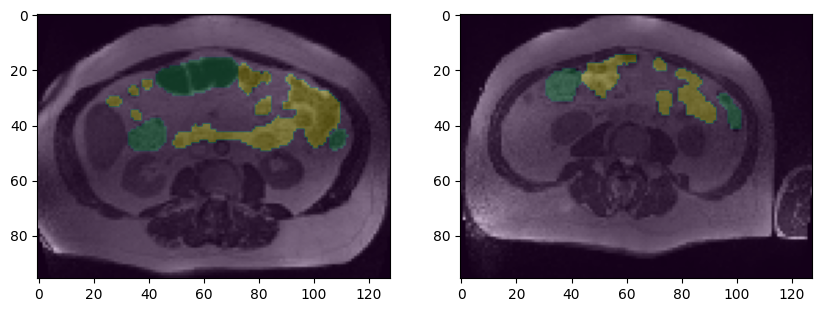

In [28]:
plt.figure(figsize=(10,16))
n = 1
for i, j in validation_processed_ds.take(2):
  plt.subplot(4,2,n)
  plt.imshow(tf.keras.preprocessing.image.array_to_img(i))
  n += 1
  plt.imshow(tf.keras.preprocessing.image.array_to_img(j), alpha=0.3)
  # plt.colorbar()

plt.show()

# **4. U-Net Model**

## **4.1. U-Net Architecture Details**

In [29]:
## **4.1. Downsampling Blocks (Encoder)**

In [30]:
# Encoder Part

def downsampling_block(input_layer, n_filters, kernel_size=3, pool_size=(2,2), dropout=0.3):
  '''
  Adds 2 convolutional layers followed by a maxpooling and dropout 
  with the parameters passed to it

  input_layer: the input tensor
  n_filters: number of filters
  kernel size: kernel size for convolution layers
  pool_size: size of maxpooled filter
  dropout: dropout ratio

  Return:
  conv_out: the output of convolution block in order to implement in the upsampling path
  block_out: the output of maxpooled and dropout layers
  '''
  # first layer
  conv_out = input_layer
  for i in range(2):
    conv_out = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
                               kernel_initializer = 'he_normal', padding = 'same')(conv_out)
    conv_out = tf.keras.layers.Activation('relu')(conv_out)

  block_out = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_out)
  block_out = tf.keras.layers.Dropout(0.3)(block_out)

  return conv_out, block_out

def downsample(inputs):
  '''
  defines the downsampling path

  inputs: batch of input images

  return:
  block_out4: the output of maxpooled features of the last encoder block
  (conv_out1, conv_out2, conv_out3, conv_out4): the output features of all encoder blocks
  '''

  conv_out1, block_out1 = downsampling_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  conv_out2, block_out2 = downsampling_block(block_out1, n_filters=128, pool_size=(2,2), dropout=0.3)
  conv_out3, block_out3 = downsampling_block(block_out2, n_filters=256, pool_size=(2,2), dropout=0.3)
  conv_out4, block_out4 = downsampling_block(block_out3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return block_out4, (conv_out1, conv_out2, conv_out3, conv_out4)

## **4.2. Bottleneck Block**

In [31]:
## **4.2. Bottleneck Block**

## **4.2. Bottleneck Block**

In [32]:
def bottleneck(inputs, n_filters=1024, kernel_size=3):
  '''
  defins the bottleneck convolution to extract more features before the upsampling layers
  '''
  bottle_neck = inputs
  for i in range(2):
    bottle_neck = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
                               kernel_initializer = 'he_normal', padding = 'same')(bottle_neck)
    bottle_neck = tf.keras.layers.Activation('relu')(bottle_neck)
  
  return bottle_neck

## **4.3. Decore Block (Upsampling)**

In [33]:
# Decoder Part

def upsampling_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
 
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides=strides, padding='same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  for i in range(2):
    c = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
                               kernel_initializer = 'he_normal', padding = 'same')(c)
    c = tf.keras.layers.Activation('relu')(c)
  
  return c

def upsample(inputs, convs, output_channels):
  

  f1, f2, f3, f4 = convs

  c6 = upsampling_block(inputs, f4, n_filters=512, kernel_size=3, strides=(2,2), dropout=0.3)
  c7 = upsampling_block(c6, f3, n_filters=256, kernel_size=3, strides=(2,2), dropout=0.3)
  c8 = upsampling_block(c7, f2, n_filters=128, kernel_size=3, strides=(2,2), dropout=0.3)
  c9 = upsampling_block(c8, f1, n_filters=64, kernel_size=3, strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1,1), padding='same', activation='softmax')(c9)

  return outputs


## **4.4. Build the U-Net Model**

I create the U-Net model by putting it all together, and chaining the encoder, bottleneck and decoder.

In [34]:
# number of output channels are equal to the number of classes
OUTPUT_CLASSES = 4

def unet():
  '''
  connect encoder, bottleneck and decoder to form UNet
  '''

  # specify the input shape
  inputs = tf.keras.layers.Input(shape=(96,128,3))

  # feed the inputs to the encoder
  encoder_ouput, convs = downsample(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_ouput)

  # feed the bottleneck and encoder outputs to the decoder
  outputs = upsample(bottle_neck, convs, output_channels=OUTPUT_CLASSES)

  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

In [35]:
# instantiate the model
model = unet()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 64)  1792        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 96, 128, 64)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 64)  36928       ['activation[0][0]']         

## **4.5. Compile and Train the Model**

In [36]:
# define the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [37]:
EPOCHS = 20
VAL_SUBSPLITS = 5
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# STEPS_PER_EPOCH = len(image_train_list) // BATCH_SIZE
# VALIDATION_STEPS = len(image_valid_list) // BATCH_SIZE // VAL_SUBSPLITS

# shuffle and group the train set to batches
train_dataset = train_processed_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# group the validation set to batches
validation_dataset = validation_processed_ds.batch(BATCH_SIZE)

In [38]:
# set the callback to stop training the model when reached 99% accuracy

class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('accuracy') is not None and logs.get('accuracy') > 0.99):
                print("\nReached 99% accuracy so cancelling training!") 
                
                # Stop training once the above condition is met
                self.model.stop_training = True

In [39]:
# fit the model
callbacks = myCallback()

with tf.device('/gpu:0'):
    model_history = model.fit(train_dataset, epochs=EPOCHS,
                          # steps_per_epoch=STEPS_PER_EPOCH,
                          # validation_steps=VALIDATION_STEPS,
                          validation_data=validation_dataset,
                          callbacks=callbacks)


Epoch 1/20


2023-05-24 15:11:24.370424: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


363/363 [==============================] - 116s 258ms/step - loss: 1.6033 - accuracy: 0.9338 - val_loss: 0.1532 - val_accuracy: 0.9462
Epoch 2/20
363/363 [==============================] - 82s 225ms/step - loss: 0.1391 - accuracy: 0.9490 - val_loss: 0.1227 - val_accuracy: 0.9550
Epoch 3/20
363/363 [==============================] - 85s 233ms/step - loss: 0.1112 - accuracy: 0.9580 - val_loss: 0.0951 - val_accuracy: 0.9644
Epoch 4/20
363/363 [==============================] - 82s 225ms/step - loss: 0.0936 - accuracy: 0.9643 - val_loss: 0.0841 - val_accuracy: 0.9678
Epoch 5/20
363/363 [==============================] - 84s 233ms/step - loss: 0.0818 - accuracy: 0.9689 - val_loss: 0.0695 - val_accuracy: 0.9733
Epoch 6/20
363/363 [==============================] - 81s 224ms/step - loss: 0.0548 - accuracy: 0.9790 - val_loss: 0.0540 - val_accuracy: 0.9793
Epoch 11/20
363/363 [==============================] - 82s 225ms/step - loss: 0.0522 - accuracy: 0.9799 - val_loss: 0.0492 - val_accuracy: 0

In [40]:
import pickle

In [ ]:

#model_history = pickle.load(open("/kaggle/input/uwmgi-mask-dataset/model.h5/model.h5","rb"))
#preds  = rf_loaded.predict(X[:1000])
#mae = mean_absolute_error(y[:1000],preds)

# 4.6. Plot the Model Accuracy

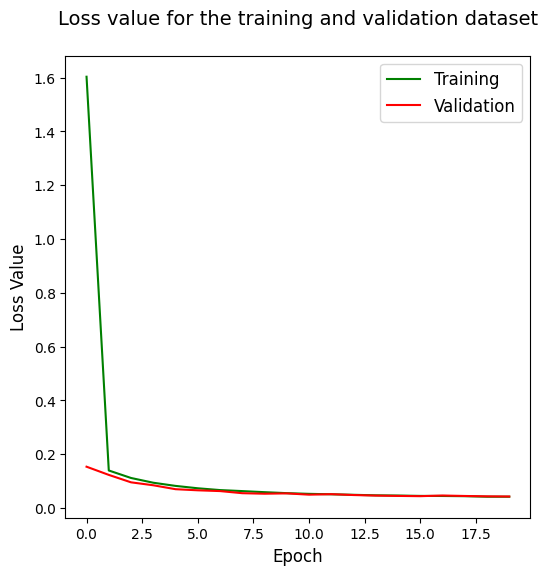

In [42]:
plt.figure(figsize=(6,6))
plt.plot(model_history.history["loss"], color='g', label='Training')
plt.plot(model_history.history["val_loss"], color='r', label='Validation')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.title('Loss value for the training and validation dataset', y=1.05, fontsize=14)
plt.legend(fontsize=12)
plt.show()

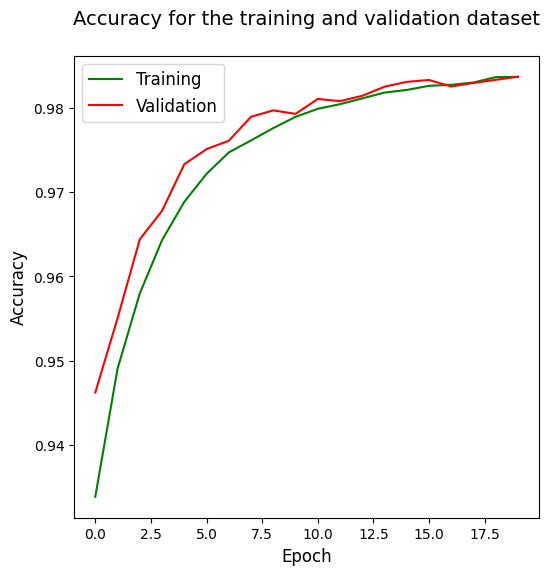

In [43]:
plt.figure(figsize=(6,6))
plt.plot(model_history.history["accuracy"], color='g', label='Training')
plt.plot(model_history.history["val_accuracy"], color='r', label='Validation')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy for the training and validation dataset', y=1.05, fontsize=14)
plt.legend(fontsize=12)
plt.show()


## **4.7. Make Predictions**

I feed the test dataset into the model and predict the mask of images. In order to do it, I define some functions for prediction and displaying it.

In [44]:
def create_mask(pred_mask):
  
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(model, image):
  
  image = np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

# 4.8. Compute Prediction Metrics

I use Intersection of Union (IOU) and Dice Score to evaluate the prediction.

\begin{align}
    IOU = \frac{Area \, of \, overlap}{Area \, of \, union}
\end{align}


\begin{align}
    Dice Score = IOU = \frac{2 * Area \, of \, overlap}{Total \, area \, of \, both \, images}
\end{align}
  


In [46]:
def class_metrics(y_true, y_pred, n_classes):
  class_iou = []
  class_dice_score = []

  smoothing_factor = 0.00001

  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    if (y_true_area == 0 and y_pred_area == 0):
      iou = (intersection + smoothing_factor) / (combined_area - intersection + smoothing_factor)
      class_iou.append(iou)

      dice_score = (intersection + smoothing_factor) / (combined_area + smoothing_factor)
      class_dice_score.append(dice_score)
    else:
      iou = intersection / (combined_area - intersection + smoothing_factor)
      class_iou.append(iou)

      dice_score = 2 * intersection / (combined_area + smoothing_factor)
      class_dice_score.append(dice_score)

  return class_iou, class_dice_score

def metrics_eval(dataset):
  n = len(list(dataset))
  iou_score = []
  dice_score = []
  for image, true_mask in dataset.take(n):
    results = model.predict(np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2])))
    results = np.argmax(results, axis=3)
    results = results[..., tf.newaxis]
    iou, dice = class_metrics(true_mask.numpy(), results, 4)
    
    iou_score.append(iou)
    dice_score.append(dice)

  avg_iou = []
  avg_dice = []

  for label in range(4):
    avg_iou.append(sum([iou_score[i][label] for i in range(len(iou_score))])/len(iou_score))
    avg_dice.append(sum([dice_score[i][label] for i in range(len(dice_score))])/len(dice_score))  
  
  return iou_score, dice_score, avg_iou, avg_dice

In [47]:
def display(dataset, num):
  '''
  plots the image, ground truth mask and predicted mask.
  display_list consists of input image, true mask and predicted mask
  '''
  for image, mask in dataset.take(num):
    image = image
    true_mask = mask
  display_list = [image, true_mask, make_predictions(model, image)]
  plt.figure(figsize=(15, 15))
  label = ['Stomach', 'Large Bowel', 'Small Bowel']

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  dice = metrics_eval(dataset.take(num))[1][-1]
  iou =  metrics_eval(dataset.take(num))[0][-1]

  string = '\n' + label[0]+' -- '+ 'dice score: ' + str(np.round(dice[1],4)) + ' /// ' + 'IOU score: ' + str(np.round(iou[1],4)) + ' \n \n' + \
           label[1]+' -- '+ 'dice score: ' + str(np.round(dice[2],4)) + ' /// ' + 'IOU score: ' + str(np.round(iou[2],4)) + ' \n \n' + \
           label[2]+' -- '+ 'dice score: ' + str(np.round(dice[3],4)) + ' /// ' + 'IOU score: ' + str(np.round(iou[3],4)) + ' \n \n' 


  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    
    plt.xticks([])
    plt.yticks([])
    plt.title(title[i], fontsize=14)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    # plt.axis('off')
  plt.xlabel(string, x =-0.7, y=3, fontsize=20)
  plt.show()

## **4.9. Calculate the average of the IOU and DICE score for each label and plot the distributions**

In [49]:
iou_results = pd.DataFrame(columns=['Label-Background', 'Label-Stomach', 'Label-Large Bowel', 'Label-Small Bowel'])
iou_results.head()

,Label-Background,Label-Stomach,Label-Large Bowel,Label-Small Bowel


In [ ]:
iou_score_train, dice_score_trian, avg_iou_train, avg_dice_train = metrics_eval(train_processed_ds)

1/1 [==============================] - ETA: 0s

In [55]:
iou_score_validation, dice_score_validation, avg_iou_validation, avg_dice_validation = metrics_eval(validation_processed_ds)

1/1 [==============================] - 0s 23ms/step


In [57]:
iou_score_test, dice_score_test, avg_iou_test, avg_dice_test = metrics_eval(test_processed_ds)

1/1 [==============================] - 0s 25ms/step


The average of IOU score for each dataset and label are summarized in the tabel below. The IOU scores of four labels are rankes as following: background, stomach, large bowel and small bowel.

In [58]:
iou_results.loc['Training Dataset - IOU Score'] = avg_iou_train
iou_results.loc['Validation Dataset - IOU Score'] = avg_iou_validation
iou_results.loc['Test Dataset - IOU Score'] = avg_iou_test
iou_results

,Label-Background,Label-Stomach,Label-Large Bowel,Label-Small Bowel
Training Dataset - IOU Score,0.985904,0.903057,0.852789,0.725133
Validation Dataset - IOU Score,0.985060,0.876374,0.827884,0.690634
Test Dataset - IOU Score,0.984787,0.874148,0.822816,0.685695


The average of DICE score for each dataset and label are summarized in the tabel below.

In [59]:
dice_results = pd.DataFrame(columns=['Label-Background', 'Label-Stomach', 'Label-Large Bowel', 'Label-Small Bowel'])
dice_results.loc['Training Dataset - Dice Score'] = avg_dice_train
dice_results.loc['Validation Dataset - Dice Score'] = avg_dice_validation
dice_results.loc['Test Dataset - Dice Score'] = avg_dice_test
dice_results

,Label-Background,Label-Stomach,Label-Large Bowel,Label-Small Bowel
Training Dataset - Dice Score,0.992879,0.932080,0.906553,0.823123
Validation Dataset - Dice Score,0.992445,0.906728,0.883506,0.791438
Test Dataset - Dice Score,0.992309,0.904780,0.880699,0.788823


I save the IOU and dice score for each label in a seperate list.

In [60]:
# IOU score of labels for the validation set
iou_score_validation_background = [iou_score_validation[i][0] for i in range(len(iou_score_validation))]
iou_score_validation_stomach = [iou_score_validation[i][1] for i in range(len(iou_score_validation))]
iou_score_validation_largebowel = [iou_score_validation[i][2] for i in range(len(iou_score_validation))]
iou_score_validation_smallbowel = [iou_score_validation[i][3] for i in range(len(iou_score_validation))]

In [61]:
# IOU score of labels for the test set
iou_score_test_background = [iou_score_test[i][0] for i in range(len(iou_score_test))]
iou_score_test_stomach = [iou_score_test[i][1] for i in range(len(iou_score_test))]
iou_score_test_largebowel = [iou_score_test[i][2] for i in range(len(iou_score_test))]
iou_score_test_smallbowel = [iou_score_test[i][3] for i in range(len(iou_score_test))]

In [62]:
# DICE score of labels for the validation set
dice_score_validation_background = [dice_score_validation[i][0] for i in range(len(dice_score_validation))]
dice_score_validation_stomach = [dice_score_validation[i][1] for i in range(len(dice_score_validation))]
dice_score_validation_largebowel = [dice_score_validation[i][2] for i in range(len(dice_score_validation))]
dice_score_validation_smallbowel = [dice_score_validation[i][3] for i in range(len(dice_score_validation))]

In [63]:
# DICE score of labels for the test set
dice_score_test_background = [dice_score_test[i][0] for i in range(len(dice_score_test))]
dice_score_test_stomach = [dice_score_test[i][1] for i in range(len(dice_score_test))]
dice_score_test_largebowel = [dice_score_test[i][2] for i in range(len(dice_score_test))]
dice_score_test_smallbowel = [dice_score_test[i][3] for i in range(len(dice_score_test))]

In [72]:
large_iou_test_stomach = [iou_score_test_stomach.index(i) for i in iou_score_test_stomach if i > 0.9 and i!=1]
large_iou_test_smallbowel = [iou_score_test_smallbowel.index(i) for i in iou_score_test_smallbowel if i > 0.9 and i!=1]
large_iou_test_largebowel = [iou_score_test_largebowel.index(i) for i in iou_score_test_largebowel if i > 0.9 and i!=1]

Large IOU score for "Stomach" label 

1/1 [==============================] - 0s 25ms/step


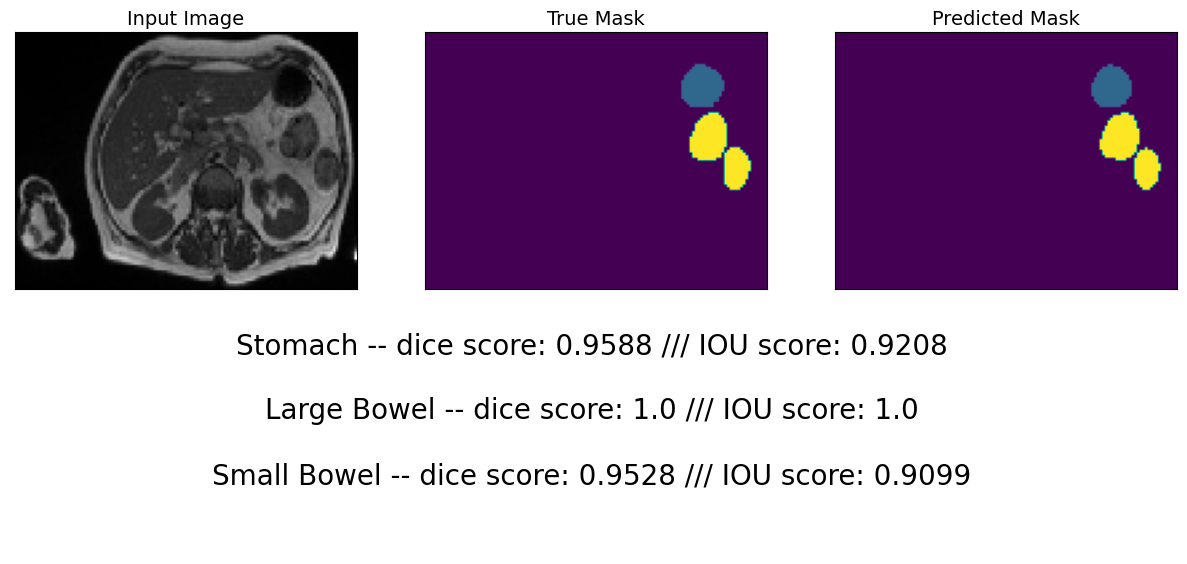

1/1 [==============================] - 0s 24ms/step


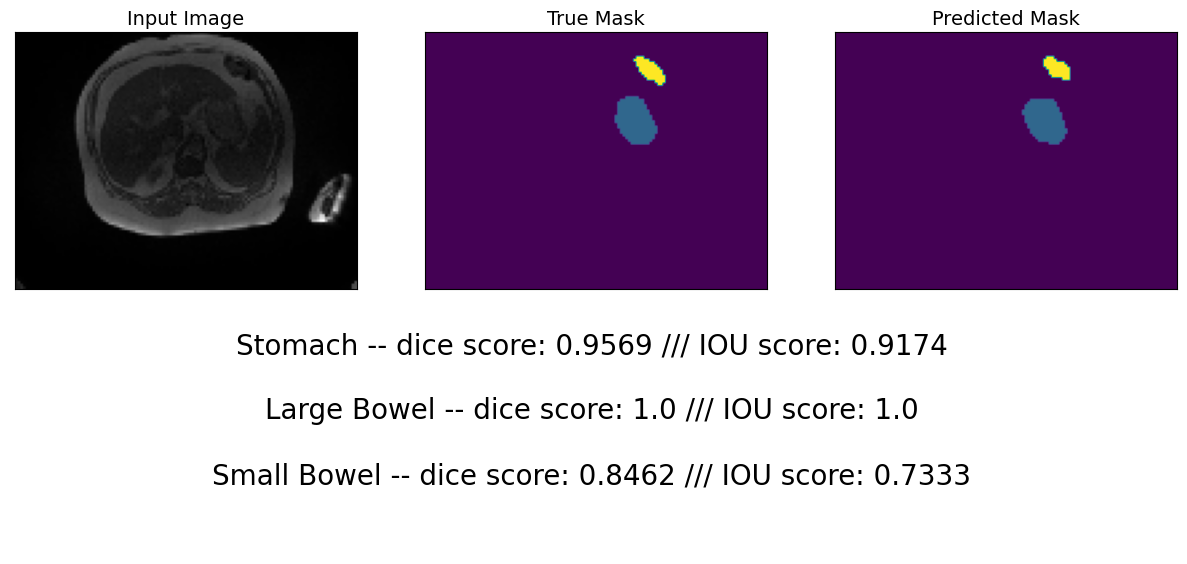

1/1 [==============================] - 0s 23ms/step


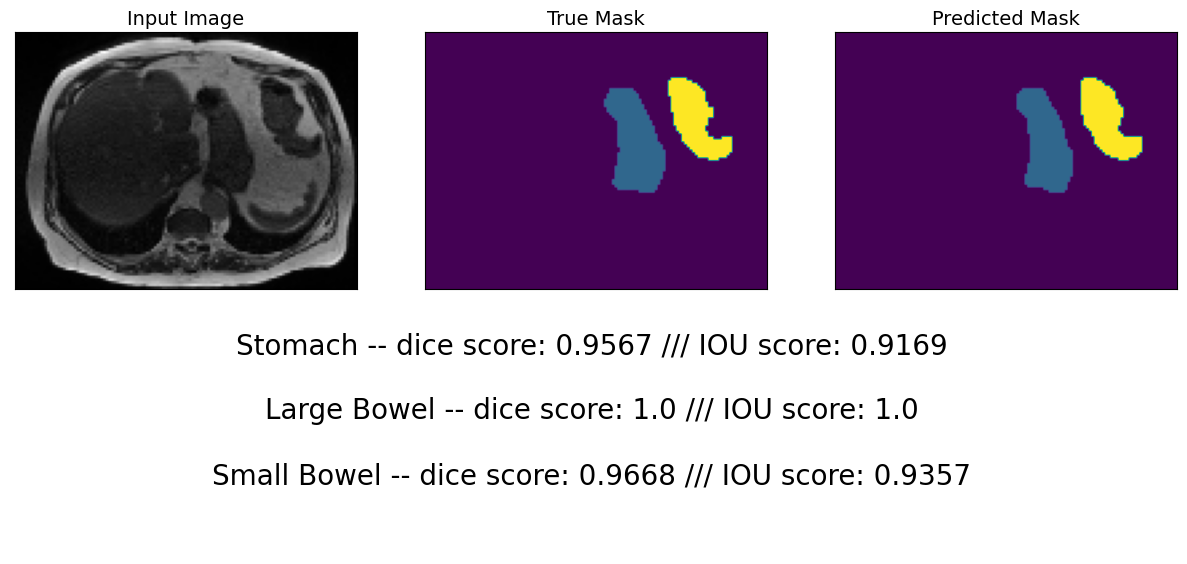

In [73]:
print('Large IOU score for "Stomach" label \n')
display(test_processed_ds, large_iou_test_stomach[0]+1)
display(test_processed_ds, large_iou_test_stomach[1]+1)
display(test_processed_ds, large_iou_test_stomach[2]+1)

Large IOU score for "Large Bowel" label 

1/1 [==============================] - 0s 29ms/step


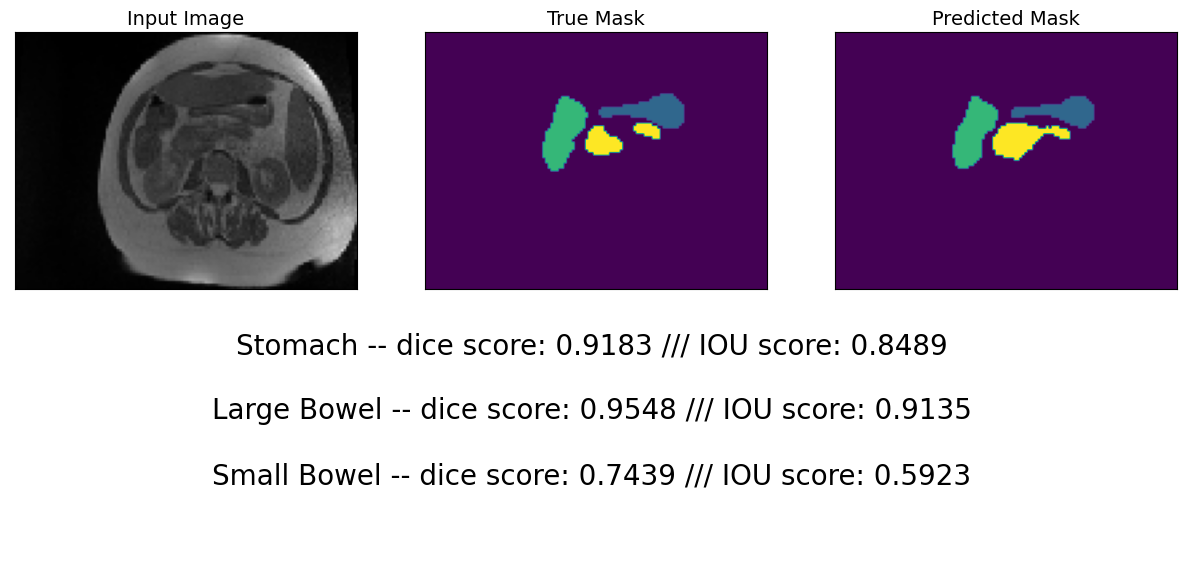

1/1 [==============================] - 0s 22ms/step


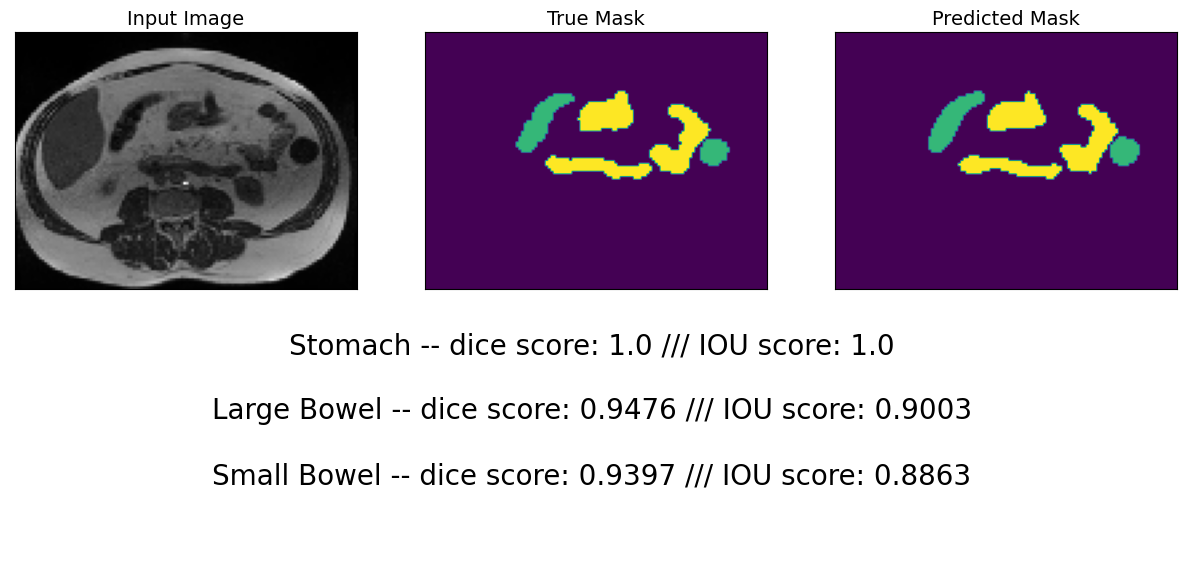

In [74]:
print('Large IOU score for "Large Bowel" label \n')
display(test_processed_ds, large_iou_test_largebowel[0]+1)
display(test_processed_ds, large_iou_test_largebowel[1]+1)


Large IOU score for "Small Bowel" label 

1/1 [==============================] - 0s 27ms/step


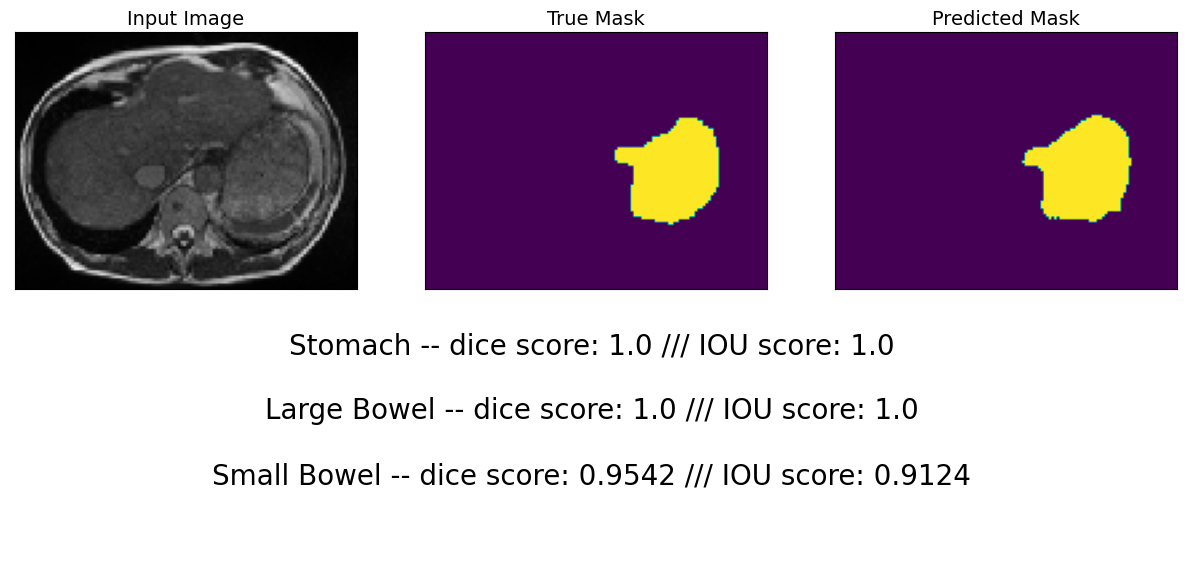

1/1 [==============================] - 0s 20ms/step


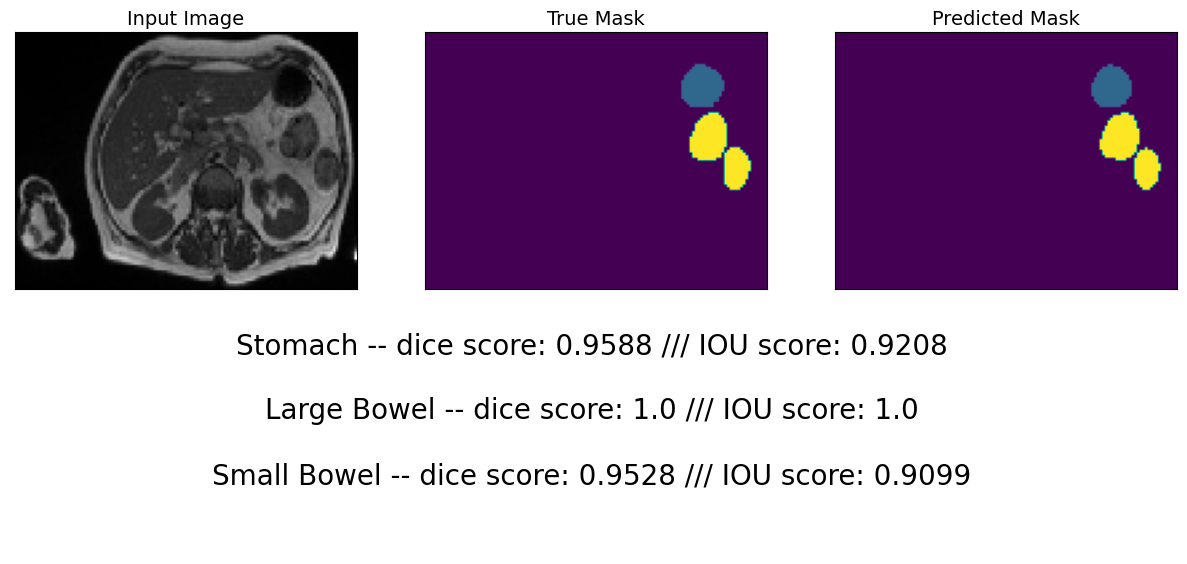

1/1 [==============================] - 0s 22ms/step


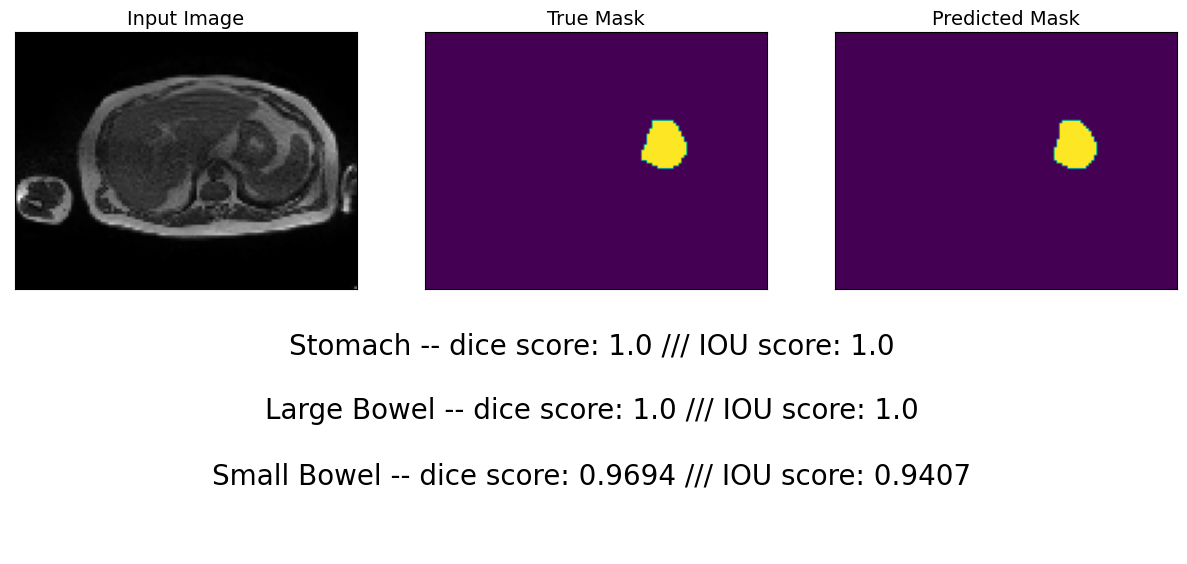

In [75]:
print('Large IOU score for "Small Bowel" label \n')
display(test_processed_ds, large_iou_test_smallbowel[0]+1)
display(test_processed_ds, large_iou_test_smallbowel[1]+1)
display(test_processed_ds, large_iou_test_smallbowel[2]+1)

Predictions with small IOU scores


In [76]:
small_iou_test_stomach = [i for i in range(len(iou_score_test_stomach)) if iou_score_test_stomach[i]<0.001]
small_iou_test_smallbowel = [i for i in range(len(iou_score_test_smallbowel)) if iou_score_test_smallbowel[i]<0.001]
small_iou_test_largebowel = [i for i in range(len(iou_score_test_stomach)) if iou_score_test_largebowel[i]<0.001]

Small IOU score for "Stomach" label 

1/1 [==============================] - 0s 24ms/step


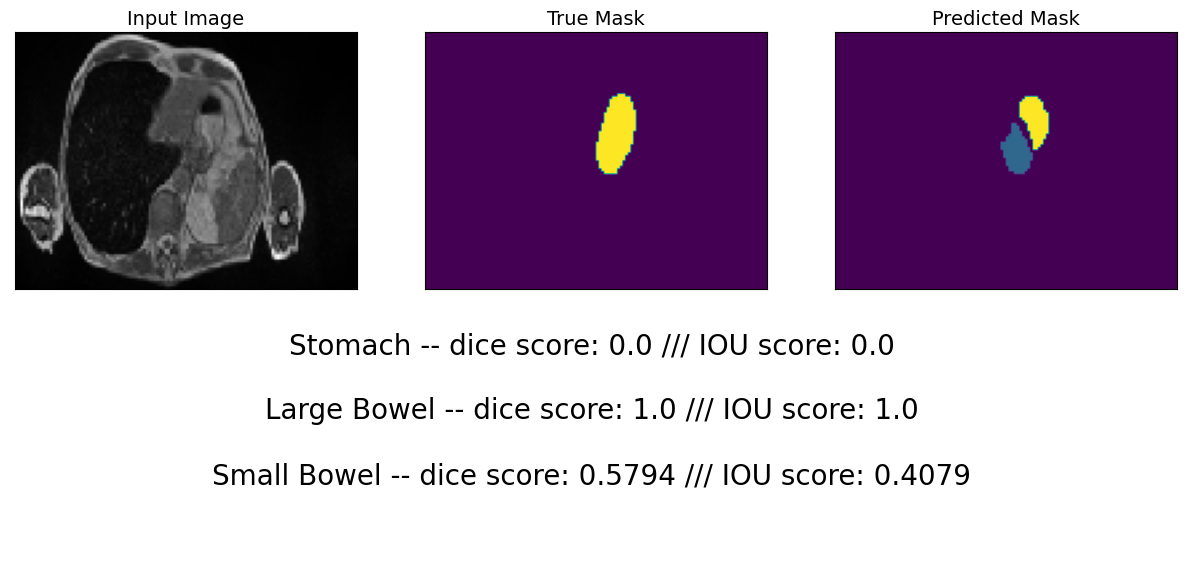

1/1 [==============================] - 0s 21ms/step


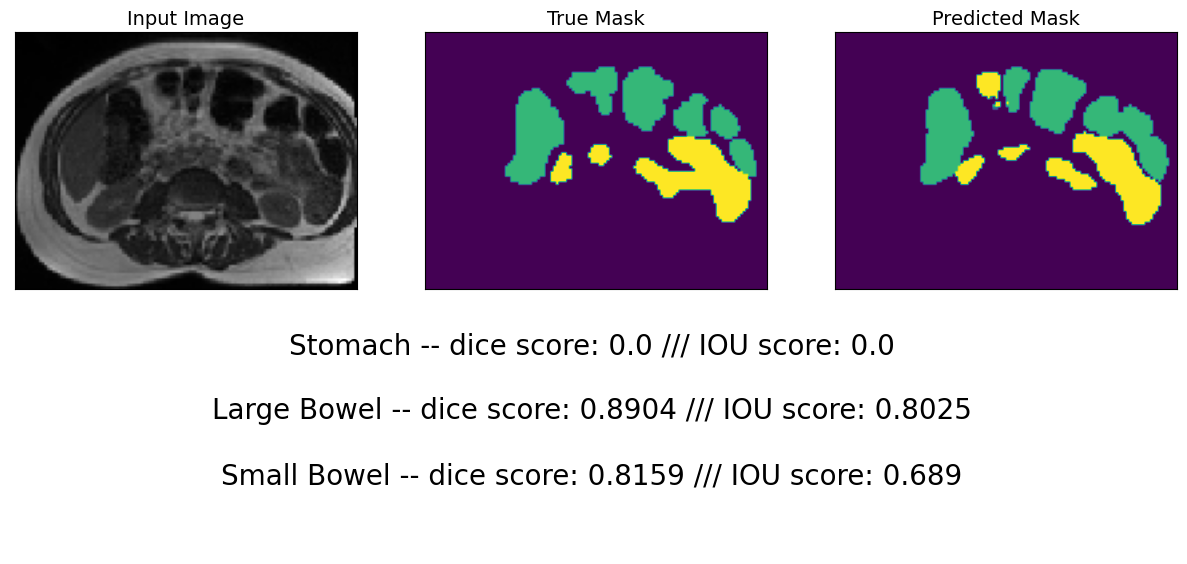

1/1 [==============================] - 0s 20ms/step


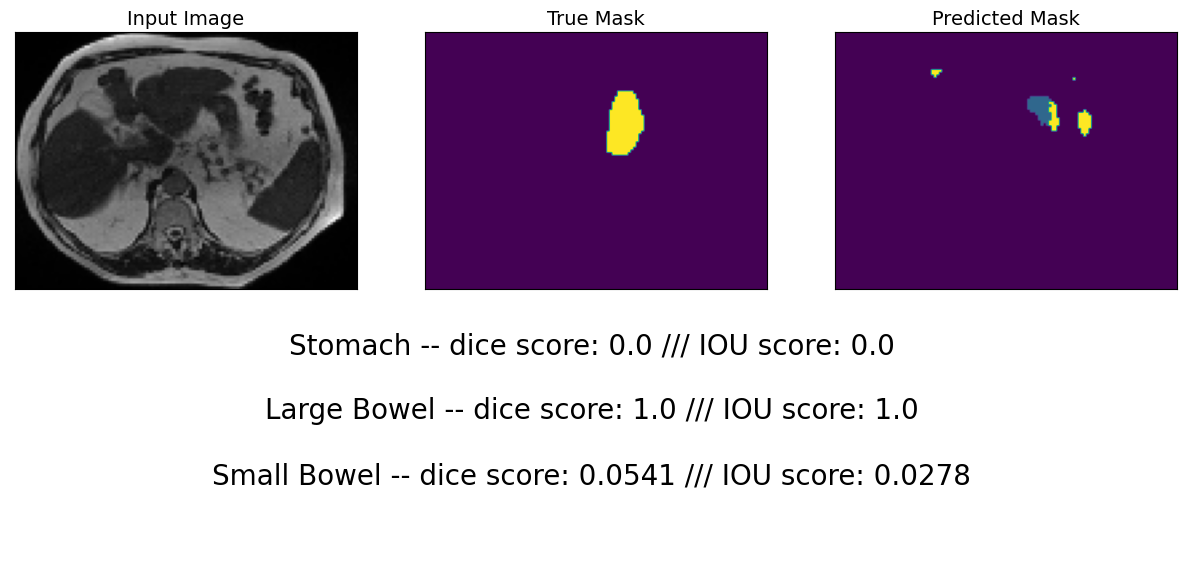

1/1 [==============================] - 0s 22ms/step


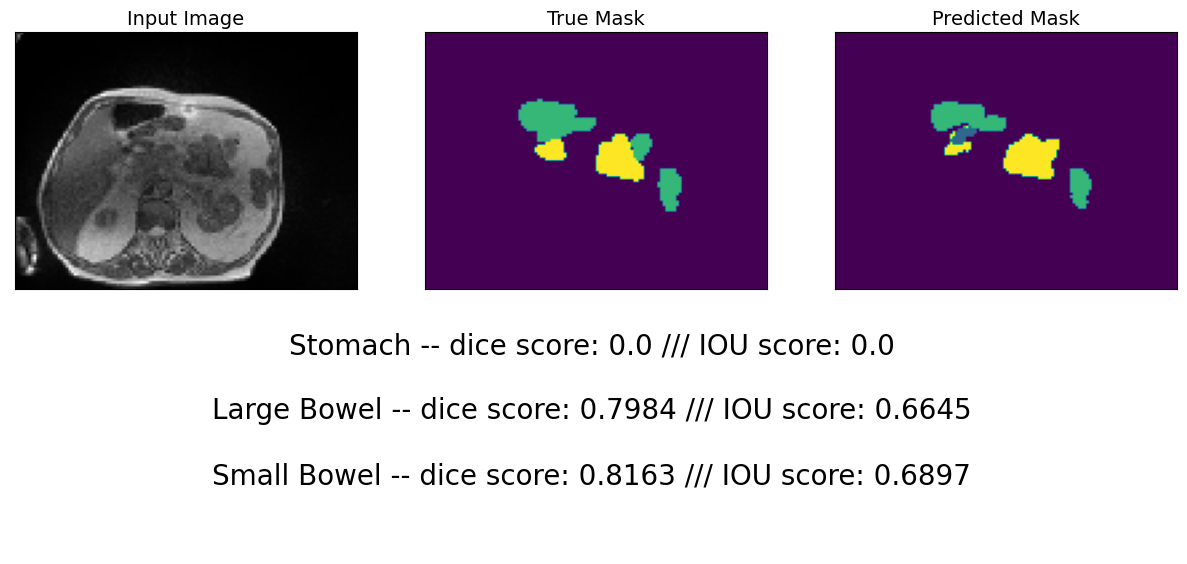

1/1 [==============================] - 0s 26ms/step


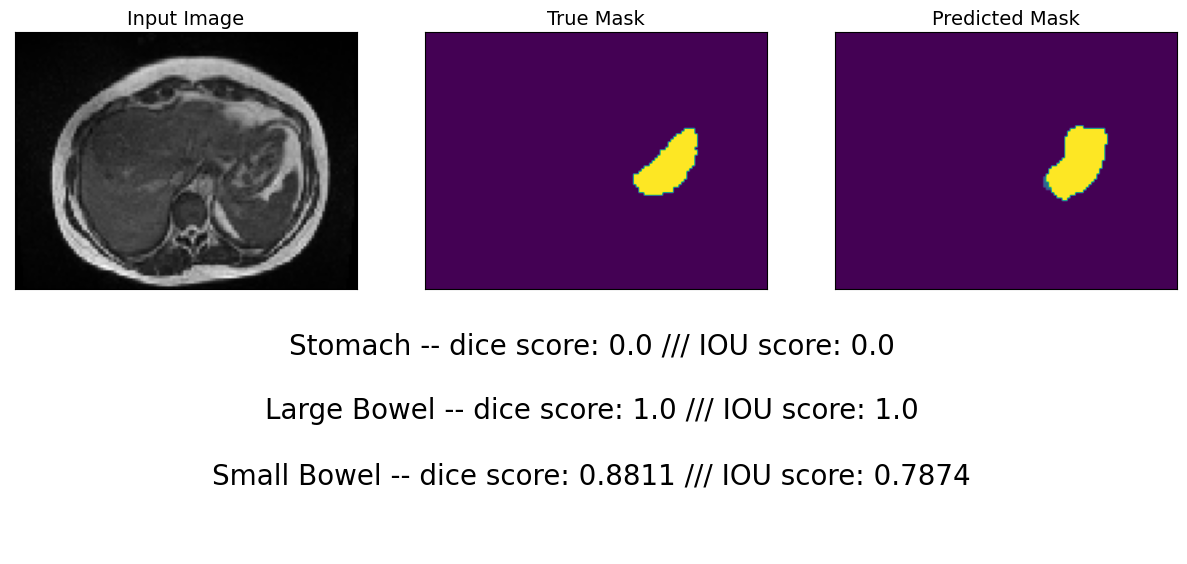

In [77]:
print('Small IOU score for "Stomach" label \n')
display(test_processed_ds, small_iou_test_stomach[0]+1)
display(test_processed_ds, small_iou_test_stomach[1]+1)
display(test_processed_ds, small_iou_test_stomach[2]+1)
display(test_processed_ds, small_iou_test_stomach[3]+1)
display(test_processed_ds, small_iou_test_stomach[4]+1)

Small IOU score for "Small bowel" label 

1/1 [==============================] - 0s 21ms/step


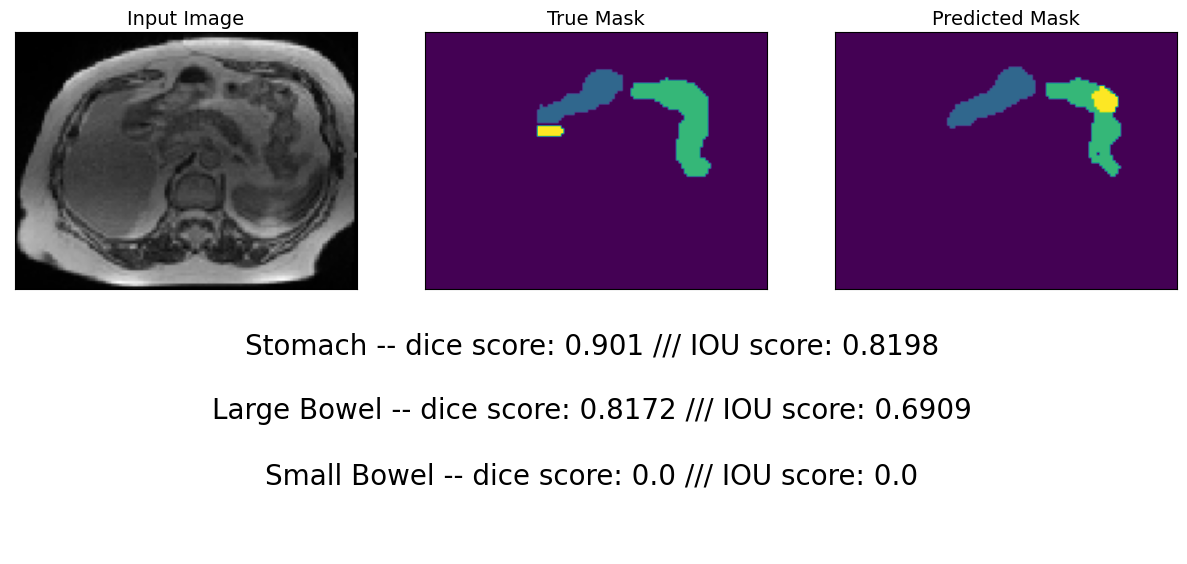

1/1 [==============================] - 0s 26ms/step


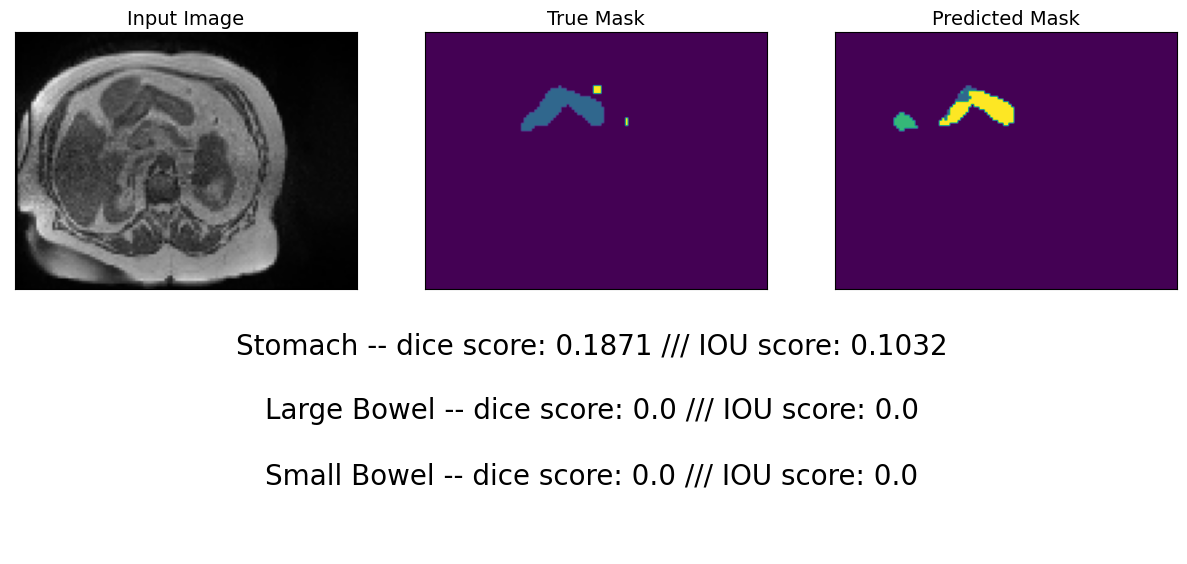

1/1 [==============================] - 0s 23ms/step


In [ ]:
print('Small IOU score for "Small bowel" label \n')
display(test_processed_ds, small_iou_test_smallbowel[10]+1)
display(test_processed_ds, small_iou_test_smallbowel[20]+1)
display(test_processed_ds, small_iou_test_smallbowel[30]+1)

Avergae Score of All Predicted Labels